In [1]:
# Importación de librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import collections
import itertools
import plotly.express as px
import plotly.graph_objects as go
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
import warnings


### 1. Cargamos los datos del set de entrenamiento

In [2]:
dataset=pd.read_csv("../data/raw/shopping_trends.csv")
dataset.head()


,Customer ID,Age,Gender,Item Purchased,Category,Purchase Amount (USD),Location,Size,Color,Season,Review Rating,Subscription Status,Payment Method,Shipping Type,Discount Applied,Promo Code Used,Previous Purchases,Preferred Payment Method,Frequency of Purchases
0,1,55,Male,Blouse,Clothing,53,Kentucky,L,Gray,Winter,3.1,Yes,Credit Card,Express,Yes,Yes,14,Venmo,Fortnightly
1,2,19,Male,Sweater,Clothing,64,Maine,L,Maroon,Winter,3.1,Yes,Bank Transfer,Express,Yes,Yes,2,Cash,Fortnightly
2,3,50,Male,Jeans,Clothing,73,Massachusetts,S,Maroon,Spring,3.1,Yes,Cash,Free Shipping,Yes,Yes,23,Credit Card,Weekly
3,4,21,Male,Sandals,Footwear,90,Rhode Island,M,Maroon,Spring,3.5,Yes,PayPal,Next Day Air,Yes,Yes,49,PayPal,Weekly
4,5,45,Male,Blouse,Clothing,49,Oregon,M,Turquoise,Spring,2.7,Yes,Cash,Free Shipping,Yes,Yes,31,PayPal,Annually


### 2. Análisis explotario de los datos -EDA-

In [3]:
dataset.columns # Visualización de columnas

Index(['Customer ID', 'Age', 'Gender', 'Item Purchased', 'Category',
       'Purchase Amount (USD)', 'Location', 'Size', 'Color', 'Season',
       'Review Rating', 'Subscription Status', 'Payment Method',
       'Shipping Type', 'Discount Applied', 'Promo Code Used',
       'Previous Purchases', 'Preferred Payment Method',
       'Frequency of Purchases'],
      dtype='object')

In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Customer ID               3900 non-null   int64  
 1   Age                       3900 non-null   int64  
 2   Gender                    3900 non-null   object 
 3   Item Purchased            3900 non-null   object 
 4   Category                  3900 non-null   object 
 5   Purchase Amount (USD)     3900 non-null   int64  
 6   Location                  3900 non-null   object 
 7   Size                      3900 non-null   object 
 8   Color                     3900 non-null   object 
 9   Season                    3900 non-null   object 
 10  Review Rating             3900 non-null   float64
 11  Subscription Status       3900 non-null   object 
 12  Payment Method            3900 non-null   object 
 13  Shipping Type             3900 non-null   object 
 14  Discount

In [5]:
# Participación por Género
gender_counts = dataset['Gender'].value_counts().reset_index()
gender_counts.columns = ['Gender', 'Count']

fig_gender = px.pie(
    gender_counts,
    names='Gender',
    values='Count',
    title='Proporción de clientes por género',
    color_discrete_sequence=px.colors.sequential.RdBu
)
fig_gender.update_layout(
    template='plotly_dark',
    plot_bgcolor='white',
    paper_bgcolor='white',
    font=dict(color='black')
)
fig_gender.show()

In [6]:
# Conteo por tamaños
size_counts = dataset['Size'].value_counts().reset_index()
size_counts.columns = ['Size', 'Count']

fig_sizes = px.bar(
    size_counts,
    x='Size',
    y='Count',
    text='Count',
    title='Tamaños preferidos',
    color_discrete_sequence=['blue']
)
fig_sizes.update_layout(
    template='plotly_dark',
    plot_bgcolor='white',
    paper_bgcolor='white',
    font=dict(color='black'),
    xaxis_title='Tamaño',
    yaxis_title='Conteo de compras'
)
fig_sizes.show()

In [7]:
# Tendencias estacionales
season_counts = dataset['Season'].value_counts().reset_index()
season_counts.columns = ['Season', 'Count']

fig_season = px.bar(
    season_counts,
    x='Season',
    y='Count',
    text='Count',
    title='Tendencias estacionales en las compras',
    color_discrete_sequence=['green']
)
fig_season.update_layout(
    template='plotly_dark',
    plot_bgcolor='white',
    paper_bgcolor='white',
    font=dict(color='black'),
    xaxis_title='Estación',
    yaxis_title='Conteo de compras'
)
fig_season.show()

In [8]:
# Count popular payment methods
payment_counts = dataset['Payment Method'].value_counts().reset_index()
payment_counts.columns = ['Payment Method', 'Count']

fig_payment = px.pie(
    payment_counts,
    names='Payment Method',
    values='Count',
    title='Métodos de pago',
    color_discrete_sequence=px.colors.sequential.Plasma
)
fig_payment.update_layout(
    template='plotly_dark',
    plot_bgcolor='white',
    paper_bgcolor='white',
    font=dict(color='black')
)
fig_payment.show()

In [9]:
# Group data by subscription status and calculate the total purchase amount
subscription_data = dataset.groupby('Subscription Status')['Purchase Amount (USD)'].sum().reset_index()

fig_subscription = px.bar(
    subscription_data,
    x='Subscription Status',
    y='Purchase Amount (USD)',
    text='Purchase Amount (USD)',
    title='Impacto de la suscripción en las compras',
    color='Subscription Status',
    color_discrete_sequence=px.colors.sequential.Viridis
)
fig_subscription.update_layout(
    template='plotly_dark',
    plot_bgcolor='white',
    paper_bgcolor='white',
    font=dict(color='black'),
    xaxis_title='Subscription Status',
    yaxis_title='Total Purchase Amount (USD)'
)
fig_subscription.show()

### Ingeniería de características

In [10]:
dataset.head()

,Customer ID,Age,Gender,Item Purchased,Category,Purchase Amount (USD),Location,Size,Color,Season,Review Rating,Subscription Status,Payment Method,Shipping Type,Discount Applied,Promo Code Used,Previous Purchases,Preferred Payment Method,Frequency of Purchases
0,1,55,Male,Blouse,Clothing,53,Kentucky,L,Gray,Winter,3.1,Yes,Credit Card,Express,Yes,Yes,14,Venmo,Fortnightly
1,2,19,Male,Sweater,Clothing,64,Maine,L,Maroon,Winter,3.1,Yes,Bank Transfer,Express,Yes,Yes,2,Cash,Fortnightly
2,3,50,Male,Jeans,Clothing,73,Massachusetts,S,Maroon,Spring,3.1,Yes,Cash,Free Shipping,Yes,Yes,23,Credit Card,Weekly
3,4,21,Male,Sandals,Footwear,90,Rhode Island,M,Maroon,Spring,3.5,Yes,PayPal,Next Day Air,Yes,Yes,49,PayPal,Weekly
4,5,45,Male,Blouse,Clothing,49,Oregon,M,Turquoise,Spring,2.7,Yes,Cash,Free Shipping,Yes,Yes,31,PayPal,Annually


### Eliminar columnas irrelevantes

In [11]:
dataset.drop(['Item Purchased', 'Frequency of Purchases', 'Previous Purchases','Review Rating'],axis=1, inplace=True)
dataset.head()

,Customer ID,Age,Gender,Category,Purchase Amount (USD),Location,Size,Color,Season,Subscription Status,Payment Method,Shipping Type,Discount Applied,Promo Code Used,Preferred Payment Method
0,1,55,Male,Clothing,53,Kentucky,L,Gray,Winter,Yes,Credit Card,Express,Yes,Yes,Venmo
1,2,19,Male,Clothing,64,Maine,L,Maroon,Winter,Yes,Bank Transfer,Express,Yes,Yes,Cash
2,3,50,Male,Clothing,73,Massachusetts,S,Maroon,Spring,Yes,Cash,Free Shipping,Yes,Yes,Credit Card
3,4,21,Male,Footwear,90,Rhode Island,M,Maroon,Spring,Yes,PayPal,Next Day Air,Yes,Yes,PayPal
4,5,45,Male,Clothing,49,Oregon,M,Turquoise,Spring,Yes,Cash,Free Shipping,Yes,Yes,PayPal


### 2. Porcentaje de nulos

In [12]:
dataset.isnull().mean()

Customer ID                 0.0
Age                         0.0
Gender                      0.0
Category                    0.0
Purchase Amount (USD)       0.0
Location                    0.0
Size                        0.0
Color                       0.0
Season                      0.0
Subscription Status         0.0
Payment Method              0.0
Shipping Type               0.0
Discount Applied            0.0
Promo Code Used             0.0
Preferred Payment Method    0.0
dtype: float64

### No existen datos faltantes o nulos

In [13]:
# Seleccionar columnas categóricas
categorical_cols = ['Gender', 'Category','Shipping Type', 'Location', 'Size','Color', 'Season', 'Subscription Status','Payment Method', 'Discount Applied', 'Promo Code Used','Preferred Payment Method']

# Aplicar Label Encoding a las columnas categóricas
le = LabelEncoder()
for col in categorical_cols:
    dataset[col] = le.fit_transform(dataset[col])

In [14]:
dataset.head()

,Customer ID,Age,Gender,Category,Purchase Amount (USD),Location,Size,Color,Season,Subscription Status,Payment Method,Shipping Type,Discount Applied,Promo Code Used,Preferred Payment Method
0,1,55,1,1,53,16,0,7,3,1,2,1,1,1,5
1,2,19,1,1,64,18,0,12,3,1,0,1,1,1,1
2,3,50,1,1,73,20,2,12,1,1,1,2,1,1,2
3,4,21,1,2,90,38,1,12,1,1,4,3,1,1,4
4,5,45,1,1,49,36,1,21,1,1,1,2,1,1,4


In [15]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype
---  ------                    --------------  -----
 0   Customer ID               3900 non-null   int64
 1   Age                       3900 non-null   int64
 2   Gender                    3900 non-null   int64
 3   Category                  3900 non-null   int64
 4   Purchase Amount (USD)     3900 non-null   int64
 5   Location                  3900 non-null   int64
 6   Size                      3900 non-null   int64
 7   Color                     3900 non-null   int64
 8   Season                    3900 non-null   int64
 9   Subscription Status       3900 non-null   int64
 10  Payment Method            3900 non-null   int64
 11  Shipping Type             3900 non-null   int64
 12  Discount Applied          3900 non-null   int64
 13  Promo Code Used           3900 non-null   int64
 14  Preferred Payment Method  3900 non-null 

### Imputamos la media en la columna Volume

In [16]:
dataset['Gender'].value_counts()


Gender
1    2652
0    1248
Name: count, dtype: int64

In [17]:
dataset.head()

,Customer ID,Age,Gender,Category,Purchase Amount (USD),Location,Size,Color,Season,Subscription Status,Payment Method,Shipping Type,Discount Applied,Promo Code Used,Preferred Payment Method
0,1,55,1,1,53,16,0,7,3,1,2,1,1,1,5
1,2,19,1,1,64,18,0,12,3,1,0,1,1,1,1
2,3,50,1,1,73,20,2,12,1,1,1,2,1,1,2
3,4,21,1,2,90,38,1,12,1,1,4,3,1,1,4
4,5,45,1,1,49,36,1,21,1,1,1,2,1,1,4


In [18]:
dataset['Age'].value_counts()

Age
69    88
57    87
41    86
25    85
49    84
54    83
27    83
50    83
62    83
32    82
58    81
19    81
42    80
31    79
28    79
43    79
37    77
29    76
46    76
63    75
59    75
68    75
56    74
36    74
52    73
64    73
55    73
51    72
65    72
45    72
40    72
35    72
47    71
66    71
30    71
23    71
53    70
38    70
18    69
26    69
21    69
34    68
39    68
48    68
24    68
70    67
22    66
61    65
60    65
33    63
20    62
67    54
44    51
Name: count, dtype: int64

In [19]:
dataset['Category'].value_counts()

Category
1    1737
0    1240
2     599
3     324
Name: count, dtype: int64

In [20]:
dataset['Purchase Amount (USD)'].value_counts()

Purchase Amount (USD)
36    62
32    62
94    62
51    61
90    60
      ..
54    36
49    35
87    35
69    34
61    33
Name: count, Length: 81, dtype: int64

In [21]:
dataset['Location'].value_counts()





Location
25    96
4     95
11    93
12    92
0     89
22    88
31    87
27    87
26    87
7     86
19    86
44    85
17    84
33    83
47    81
24    81
30    81
23    80
16    79
3     79
9     79
13    79
6     78
32    78
18    77
34    77
45    77
42    77
41    77
39    76
35    75
48    75
5     75
36    74
37    74
21    73
46    73
1     72
20    72
43    71
49    71
28    71
40    70
14    69
8     68
29    67
2     65
10    65
38    63
15    63
Name: count, dtype: int64

In [22]:
dataset['Size'].value_counts()


Size
1    1755
0    1053
2     663
3     429
Name: count, dtype: int64

In [23]:
dataset['Color'].value_counts()


Color
13    177
24    174
19    173
20    172
8     169
1     167
5     166
22    166
7     159
12    158
14    154
4     153
16    153
2     152
11    152
17    151
15    149
18    148
0     147
9     147
10    147
21    145
23    142
3     141
6     138
Name: count, dtype: int64

In [24]:
dataset['Season'].value_counts()


Season
1    999
0    975
3    971
2    955
Name: count, dtype: int64

In [25]:
dataset['Subscription Status'].value_counts()


Subscription Status
0    2847
1    1053
Name: count, dtype: int64

In [26]:
dataset['Payment Method'].value_counts()


Payment Method
2    696
5    653
1    648
4    638
3    633
0    632
Name: count, dtype: int64

In [27]:
dataset['Shipping Type'].value_counts()


Shipping Type
2    675
4    654
5    650
3    648
1    646
0    627
Name: count, dtype: int64

In [28]:
dataset['Discount Applied'].value_counts()

Discount Applied
0    2223
1    1677
Name: count, dtype: int64

In [29]:
dataset['Promo Code Used'].value_counts()

Promo Code Used
0    2223
1    1677
Name: count, dtype: int64

In [30]:
dataset['Preferred Payment Method'].value_counts()

Preferred Payment Method
4    677
2    671
1    670
3    636
5    634
0    612
Name: count, dtype: int64

In [31]:
dataset.head()

,Customer ID,Age,Gender,Category,Purchase Amount (USD),Location,Size,Color,Season,Subscription Status,Payment Method,Shipping Type,Discount Applied,Promo Code Used,Preferred Payment Method
0,1,55,1,1,53,16,0,7,3,1,2,1,1,1,5
1,2,19,1,1,64,18,0,12,3,1,0,1,1,1,1
2,3,50,1,1,73,20,2,12,1,1,1,2,1,1,2
3,4,21,1,2,90,38,1,12,1,1,4,3,1,1,4
4,5,45,1,1,49,36,1,21,1,1,1,2,1,1,4


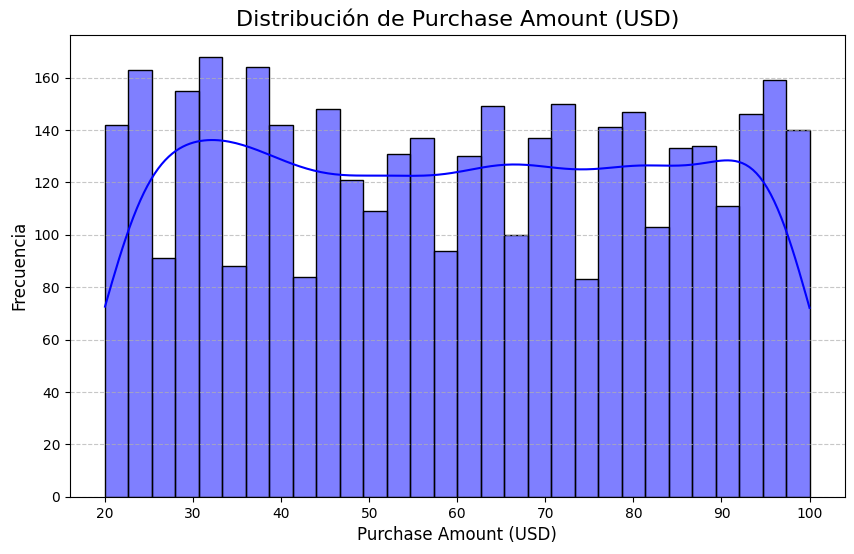

count    3900.000000
mean       59.764359
std        23.685392
min        20.000000
25%        39.000000
50%        60.000000
75%        81.000000
max       100.000000
Name: Purchase Amount (USD), dtype: float64

In [32]:
import seaborn as sns

# Visualización de la distribución de 'Purchase Amount (USD)'
plt.figure(figsize=(10, 6))
sns.histplot(dataset['Purchase Amount (USD)'], kde=True, bins=30, color='blue')
plt.title('Distribución de Purchase Amount (USD)', fontsize=16)
plt.xlabel('Purchase Amount (USD)', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Resumen estadístico del objetivo
dataset['Purchase Amount (USD)'].describe()

La distribución parece aproximadamente simétrica, aunque podría tener un ligero sesgo hacia los extremos (valores bajos o altos).

### 4. Estandarización de Variables

In [33]:
from sklearn.preprocessing import MinMaxScaler

In [34]:
from sklearn.preprocessing import StandardScaler

# Crear una copia del dataset original
scaled_dataset = dataset.copy()



In [35]:
mm_scaler = MinMaxScaler()

X= dataset.drop('Purchase Amount (USD)', axis=1)
scaled_feature= mm_scaler.fit_transform(X)
scaled_df=pd.DataFrame(scaled_feature,columns=X.columns)

In [36]:
scaled_dataset['Purchase Amount (USD)']=dataset['Purchase Amount (USD)']
scaled_dataset.head()

,Customer ID,Age,Gender,Category,Purchase Amount (USD),Location,Size,Color,Season,Subscription Status,Payment Method,Shipping Type,Discount Applied,Promo Code Used,Preferred Payment Method
0,1,55,1,1,53,16,0,7,3,1,2,1,1,1,5
1,2,19,1,1,64,18,0,12,3,1,0,1,1,1,1
2,3,50,1,1,73,20,2,12,1,1,1,2,1,1,2
3,4,21,1,2,90,38,1,12,1,1,4,3,1,1,4
4,5,45,1,1,49,36,1,21,1,1,1,2,1,1,4


In [37]:
scaled_dataset.to_csv('../data/processed/features_for_model.csv')